In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
import numpy as np
import tensorflow as tf
import os


X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train)

[[   0    0    0 ...   20   33  748]
 [   0    0    0 ...   15   44  391]
 [   0    0    0 ...   24  205    2]
 ...
 [   0    0    0 ... 2710    6   18]
 [   0    0    0 ...   60  395 8572]
 [   0    0    0 ...   88 2740    5]]


In [7]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [8]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수

# 시퀀셜 api로 모델 작성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=6  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/6
266/266 [==============================] - 5s 6ms/step - loss: 0.4758 - accuracy: 0.7682 - val_loss: 0.3505 - val_accuracy: 0.8480
Epoch 2/6
266/266 [==============================] - 1s 5ms/step - loss: 0.3256 - accuracy: 0.8615 - val_loss: 0.3359 - val_accuracy: 0.8544
Epoch 3/6
266/266 [==============================] - 1s 5ms/step - loss: 0.2931 - accuracy: 0.8776 - val_loss: 0.3344 - val_accuracy: 0.8536
Epoch 4/6
266/266 [==============================] - 1s 5ms/step - loss: 0.2654 - accuracy: 0.8919 - val_loss: 0.3350 - val_accuracy: 0.8596
Epoch 5/6
266/266 [==============================] - 1s 5ms/step - loss: 0.2338 - accuracy: 0.9080 - val_loss: 0.3495 - val_accuracy: 0.8519
Epoch 6/6
266/266 [==============================] - 1s 5ms/step - loss: 0.2014 - accuracy: 0.9236 - val_loss: 0.3765 - val_accuracy: 0.8489
1537/1537 - 3s - loss: 0.3850 - accuracy: 0.8469
[0.3850175142288208, 0.8468783497810364]


In [10]:
history_dict = history.history
print(history_dict.keys()) # ep

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


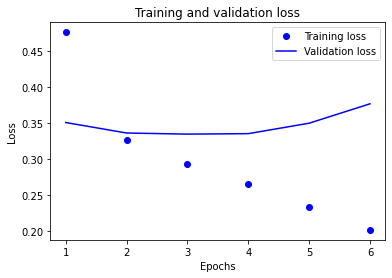

In [11]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

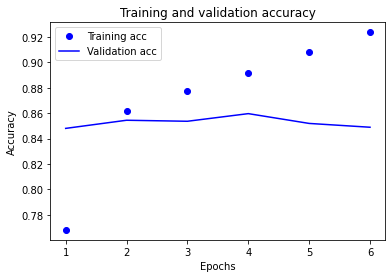

In [12]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epochs 3회부터 로스가 오른다

## 임베딩 레이어 분석

In [13]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [14]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [15]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.0863001 , -0.0025279 , -0.11331655,  0.0536409 ,  0.09347736,
       -0.0151139 , -0.24129346, -0.02613937,  0.19300443,  0.04803979,
       -0.00683249, -0.0128551 ,  0.0201176 , -0.05606556,  0.00246879,
        0.05950334], dtype=float32)

In [16]:
word_vectors.similar_by_word("쓰레기")

[('개뿔', 0.9453624486923218),
 ('조잡', 0.94145667552948),
 ('민망', 0.9368619918823242),
 ('배슬기', 0.9357537627220154),
 ('짜집', 0.9355328679084778),
 ('체자', 0.934526264667511),
 ('잡탕', 0.9339403510093689),
 ('초보', 0.9310812950134277),
 ('볼라', 0.930091142654419),
 ('혐', 0.9273268580436707)]

In [17]:
# 두번째 모델
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수

# 시퀀셜 api로 모델 작성
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.Dense(16, activation='relu'))
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
dense_2 (Dense)              (None, None, 16)          272       
_________________________________________________________________
dense_3 (Dense)              (None, None, 8)           136       
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           9         
Total params: 160,417
Trainable params: 160,417
Non-trainable params: 0
_________________________________________________________________


In [18]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model1.evaluate(X_test,  y_test, verbose=2)

print(results)

history_dict = history.history
print(history_dict.keys()) # ep

Epoch 1/10
266/266 [==============================] - 2s 5ms/step - loss: 0.6803 - accuracy: 0.5389 - val_loss: 0.6742 - val_accuracy: 0.5443
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6734 - accuracy: 0.5430 - val_loss: 0.6741 - val_accuracy: 0.5446
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6729 - accuracy: 0.5445 - val_loss: 0.6739 - val_accuracy: 0.5395
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6726 - accuracy: 0.5439 - val_loss: 0.6736 - val_accuracy: 0.5450
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6725 - accuracy: 0.5448 - val_loss: 0.6736 - val_accuracy: 0.5442
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6724 - accuracy: 0.5443 - val_loss: 0.6736 - val_accuracy: 0.5450
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.6724 - accuracy: 0.5441 - val_loss: 0.6737 - val_accuracy: 0.5446
Epoch 

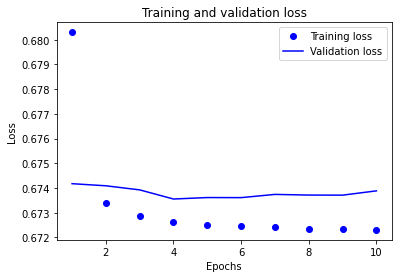

In [19]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

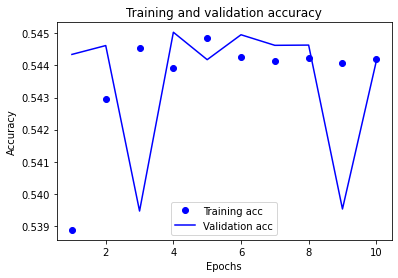

In [20]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

단일 maxpooling

In [21]:
vocab_size = 10000
word_vector_dim = 16 

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [22]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

history_dict = history.history
print(history_dict.keys()) # ep

Epoch 1/10
266/266 [==============================] - 1s 4ms/step - loss: 0.5818 - accuracy: 0.7312 - val_loss: 0.4133 - val_accuracy: 0.8278
Epoch 2/10
266/266 [==============================] - 1s 4ms/step - loss: 0.3718 - accuracy: 0.8412 - val_loss: 0.3528 - val_accuracy: 0.8427
Epoch 3/10
266/266 [==============================] - 1s 3ms/step - loss: 0.3254 - accuracy: 0.8618 - val_loss: 0.3451 - val_accuracy: 0.8477
Epoch 4/10
266/266 [==============================] - 1s 3ms/step - loss: 0.3003 - accuracy: 0.8744 - val_loss: 0.3448 - val_accuracy: 0.8491
Epoch 5/10
266/266 [==============================] - 1s 3ms/step - loss: 0.2815 - accuracy: 0.8836 - val_loss: 0.3489 - val_accuracy: 0.8489
Epoch 6/10
266/266 [==============================] - 1s 3ms/step - loss: 0.2667 - accuracy: 0.8911 - val_loss: 0.3548 - val_accuracy: 0.8487
Epoch 7/10
266/266 [==============================] - 1s 3ms/step - loss: 0.2543 - accuracy: 0.8967 - val_loss: 0.3623 - val_accuracy: 0.8464
Epoch 

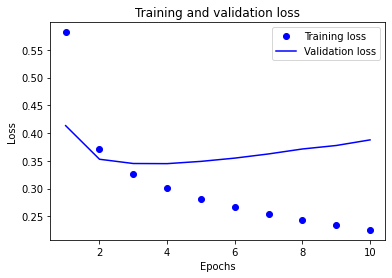

In [23]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

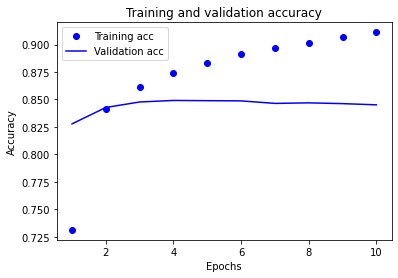

In [24]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

한국어 Word2Vec 임베딩 활용하여 성능 개선

In [25]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_ko.model'
print(word2vec_path)
word2vec = Word2VecKeyedVectors.load(word2vec_path)
vector = word2vec.wv['쓰레기']
vector

/aiffel/aiffel/sentiment_classification/word2vec_ko.model


array([ 0.7476648 , -0.18833444,  0.5228705 , -0.28470796,  0.1743449 ,
        0.5392188 , -0.45038474, -0.15583575,  0.25813106,  2.1101398 ,
       -0.10038859,  1.9824587 , -2.4543462 ,  0.25453645, -0.08350416,
        0.27441242,  1.9425403 ,  1.3369328 ,  2.5706255 , -2.0128593 ,
       -2.2959113 ,  1.0654615 , -1.1901352 ,  0.8687114 ,  0.25150904,
       -0.24499871,  0.31551868,  1.4217411 ,  2.404705  , -1.2435211 ,
        1.3495855 ,  0.27344066, -0.90432566,  1.892138  ,  0.4035198 ,
       -3.3962784 , -2.0232077 , -1.2729341 ,  0.35647452, -0.33404827,
        1.3049135 , -1.7490015 , -1.8954306 , -0.22241116, -1.3650101 ,
        2.6746683 ,  0.7940145 , -0.98530763,  0.92288804, -1.2526557 ,
       -0.13688333, -1.0034893 ,  1.2474568 ,  0.53813857, -1.0627321 ,
       -0.44392255,  1.6472176 , -1.4686166 ,  0.24987803,  1.5133729 ,
        0.8353444 ,  0.704386  ,  0.14599314, -0.8708888 , -1.7817265 ,
       -3.3333166 , -3.145793  ,  1.631907  ,  0.3355912 ,  2.55

In [26]:
word2vec.wv.similar_by_word("쓰레기")

[('폐수', 0.7665826082229614),
 ('폐기물', 0.7611044049263),
 ('지하수', 0.6931558847427368),
 ('식수', 0.6897722482681274),
 ('더미', 0.6853598356246948),
 ('분뇨', 0.6837668418884277),
 ('소각장', 0.6801149249076843),
 ('하수', 0.6774406433105469),
 ('모래', 0.662295401096344),
 ('음식물', 0.6603024005889893)]

In [27]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [41]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 100

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 1,044,353
Trainable params: 1,044,353
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/7
266/266 [==============================] - 4s 8ms/step - loss: 0.4764 - accuracy: 0.7674 - val_loss: 0.3920 - val_accuracy: 0.8228
Epoch 2/7
266/266 [==============================] - 2s 7ms/step - loss: 0.3554 - accuracy: 0.8430 - val_loss: 0.3446 - val_accuracy: 0.8461
Epoch 3/7
266/266 [==============================] - 2s 7ms/step - loss: 0.3129 - accuracy: 0.8657 - val_loss: 0.3301 - val_accuracy: 0.8559
Epoch 4/7
266/266 [==============================] - 2s 7ms/step - loss: 0.2878 - accuracy: 0.8776 - val_loss: 0.3233 - val_accuracy: 0.8574
Epoch 5/7
266/266 [==============================] - 2s 7ms/step - loss: 0.2660 - accuracy: 0.8894 - val_loss: 0.3249 - val_accuracy: 0.8591
Epoch 6/7
266/266 [==============================] - 2s 7ms/step - loss: 0.2502 - accuracy: 0.8963 - val_loss: 0.3252 - val_accuracy: 0.8595
Epoch 7/7
266/266 [==============================] - 2s 7ms/step - loss: 0.2333 - accuracy: 0.9049 - val_loss: 0.3273 - val_accuracy: 0.8596


In [43]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3389 - accuracy: 0.8587
[0.33893129229545593, 0.8587383031845093]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


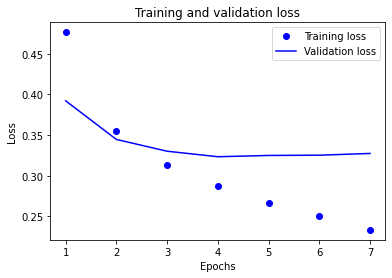

In [44]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

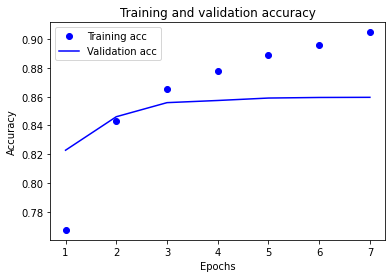

In [45]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()